# 1. Perkenalan

```
Nama        : Dini Anggriyani
Batch       : HCK-023
Objective   :
Program ini dibuat untuk memprediksi jenis kulit yang nantinya digunakan untuk membantu dokter memberikan rekomendasi treatment dan membantu customer menentukan skincare yang hendak dibeli.
```

## Problem Statement

[URL Dataset](https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset)


Problem yang hendak diselesaikan:

Pengguna sering kali mengalami kesulitan dalam pemilihan jenis skincare dan perawatan sesuai dengan jenis wajah. Tak jarang wajah menjadi kemerahan bahkan iritasi akibat penggunaan skincare/treatment yang tidak sesuai. Oleh karena itu, aplikasi ini hadir untuk membantu pengguna dalam menentukan skincare sebelum melakukan pembelian agar tidak salah pilih dan berakibat iritasi kulit. Aplikasi ini juga dapat digunakan untuk membantu dokter kulit dalam menentukan jenis kulit wajah pasien agar dapat memberikan rekomendasi treatment yang sesuai



Justifikasi:

Pemilihan skincare dan cara perawatan kulit sesuai dengan jenis kulit wajah sangat penting untuk dilakukan untuk menghindari terjadinya iritasi dan masalah kulit lain yang timbul setelahnya. Berikut merupakan justifikasi dari hal tersebut:
* [Why It Is Matter to Know Your Skin Type](https://health.clevelandclinic.org/understanding-skin-types)
* [A Guide to Taking Care of Your Skin](https://www.healthline.com/health/beauty-skin-care/skin-types-care#skin-care-dos)
* [Dampak Penggunaan Skincare yang Tidak Sesuai](https://www.idntimes.com/life/women/zfz-1685331995-jel/dampak-saat-gunakan-skincare-yang-gak-sesuai-jenis-kulit-c1c2)


User:

Pengguna yang hendak melakukan pembelian skincare dan/tau dokter kecantikan agar dapat memberikan rekomendasi treatment yang sesuai kepada pasien

# 2. Import Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path

#EDA
from PIL import Image
import numpy as np
import cv2
from skimage.feature import local_binary_pattern


#ANN
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Data Loading

Install Kaggle

In [2]:
!pip install kaggle

Make a directory

In [3]:
!mkdir ~/.kaggle

Copy the kaggle.json into new directory

In [4]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


Change permission for this directory

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
## Copy the kaggle.json into this new directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [8]:
%%time
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset

!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset

Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): apache-2.0
 96% 120M/124M [00:00<00:00, 143MB/s]
100% 124M/124M [00:00<00:00, 139MB/s]
CPU times: user 32.8 ms, sys: 3.34 ms, total: 36.2 ms
Wall time: 2.72 s


In [9]:
# Every dataset that downloaded from Kaggle, is in format `.zip`. So, we must unzip it before we can using the dataset.

!unzip -q ./oily-dry-and-normal-skin-types-dataset.zip

In [10]:
# Define path

main_path = '/content/Oily-Dry-Skin-Types/'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')
val_path = os.path.join(main_path, 'valid')

In [11]:
print(os.listdir('/content'))


['.config', 'Oily-Dry-Skin-Types', 'oily-dry-and-normal-skin-types-dataset.zip', 'drive', 'sample_data']


In [12]:
# Check how many data in `train_path` and `test_path`

def check_path(path):
  labels = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

print('Val Path')
check_path(val_path)
print('')

Train Path
Total Data - normal : 1104
Total Data - dry : 652
Total Data - oily : 1000

Test Path
Total Data - normal : 59
Total Data - dry : 35
Total Data - oily : 40

Val Path
Total Data - normal : 111
Total Data - dry : 71
Total Data - oily : 80



In [13]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  normal


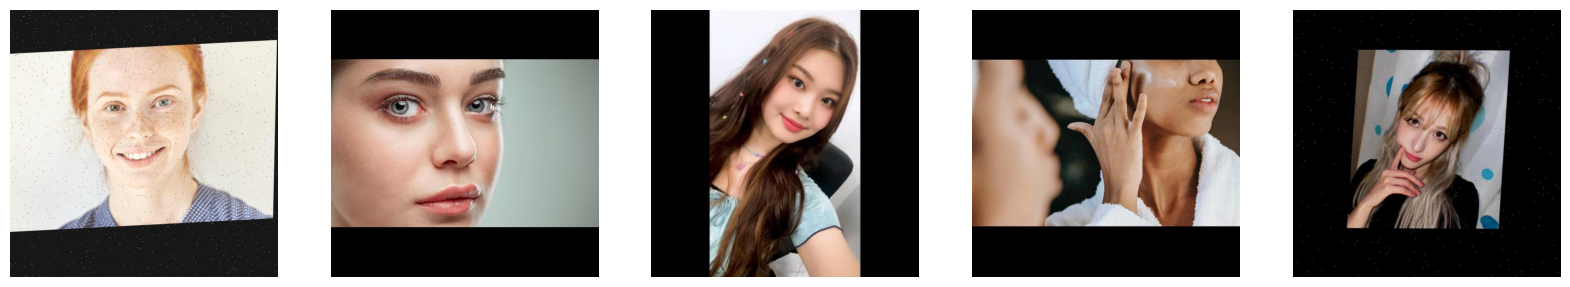

Class :  dry


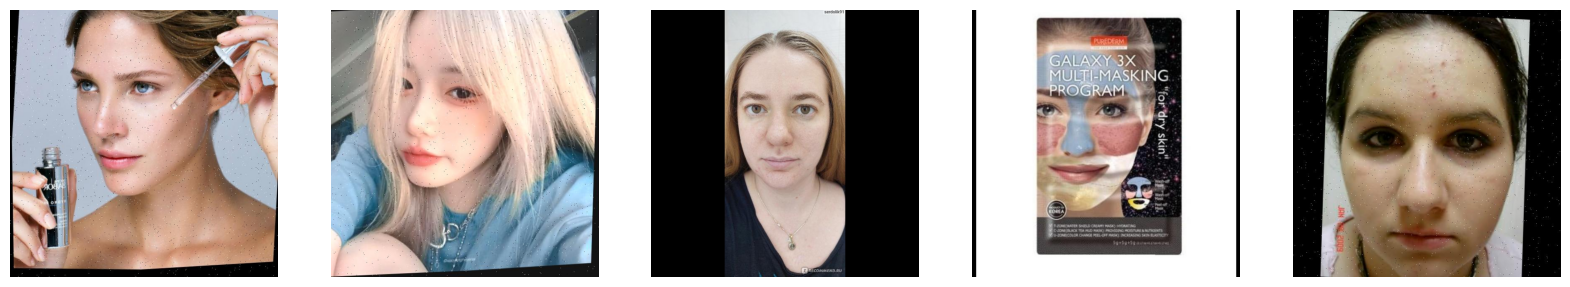

Class :  oily


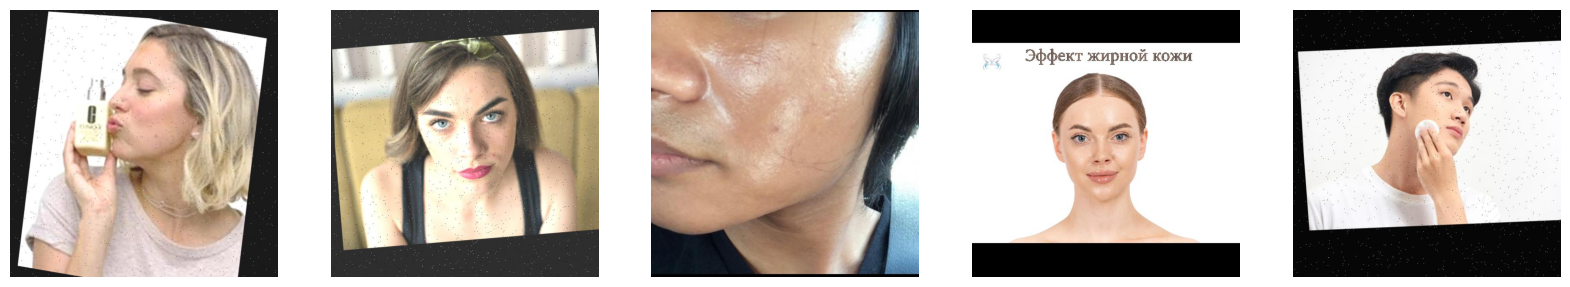

In [14]:
# Visualization of train_path

plot_images(train_path)

Class :  normal


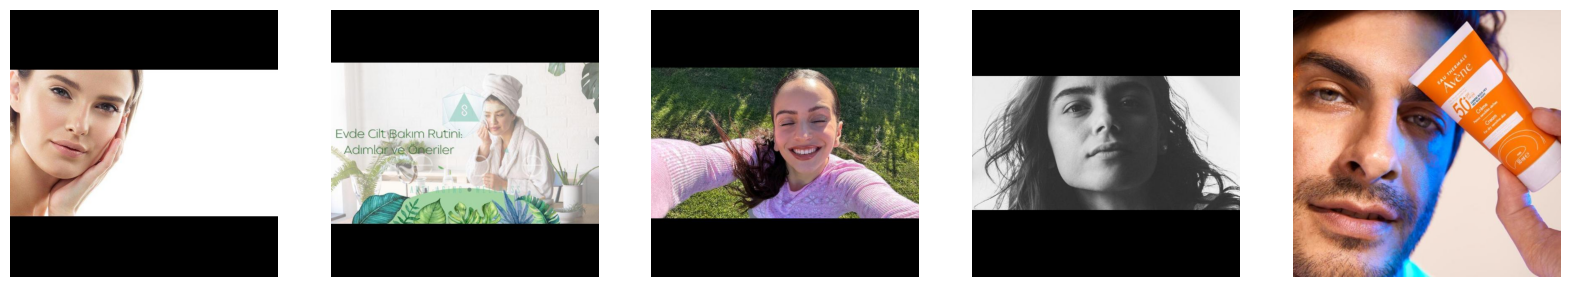

Class :  dry


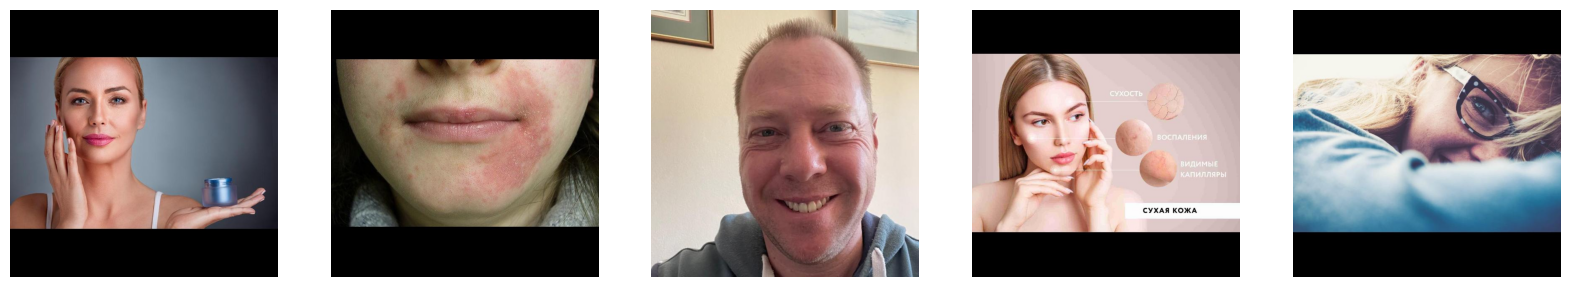

Class :  oily


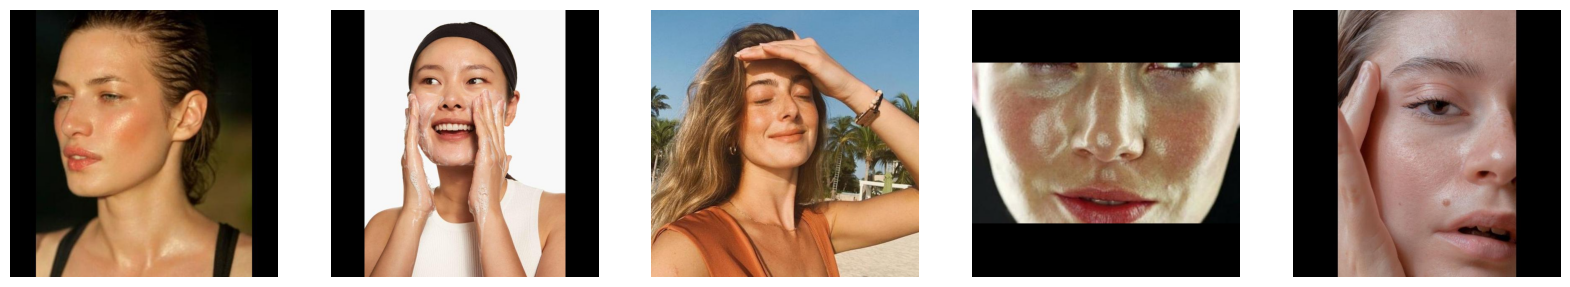

In [15]:
# Visualization of test_path

plot_images(test_path)

Class :  normal


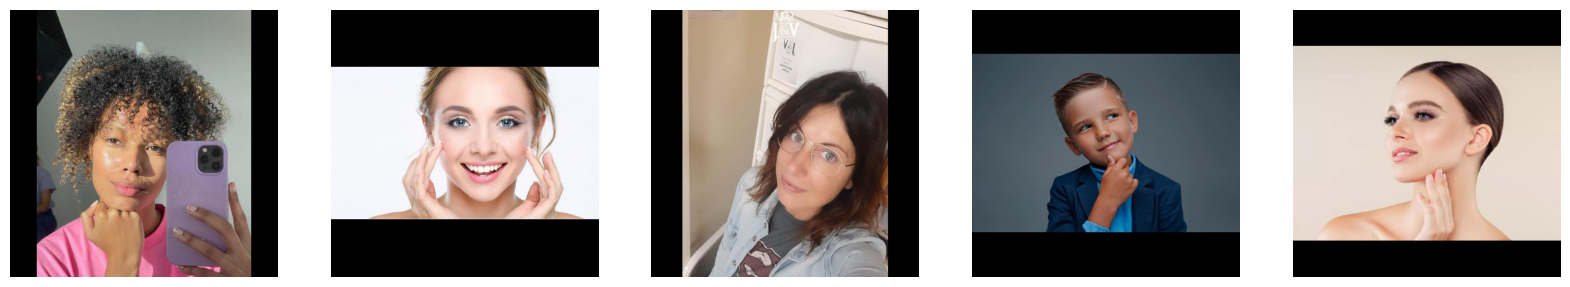

Class :  dry


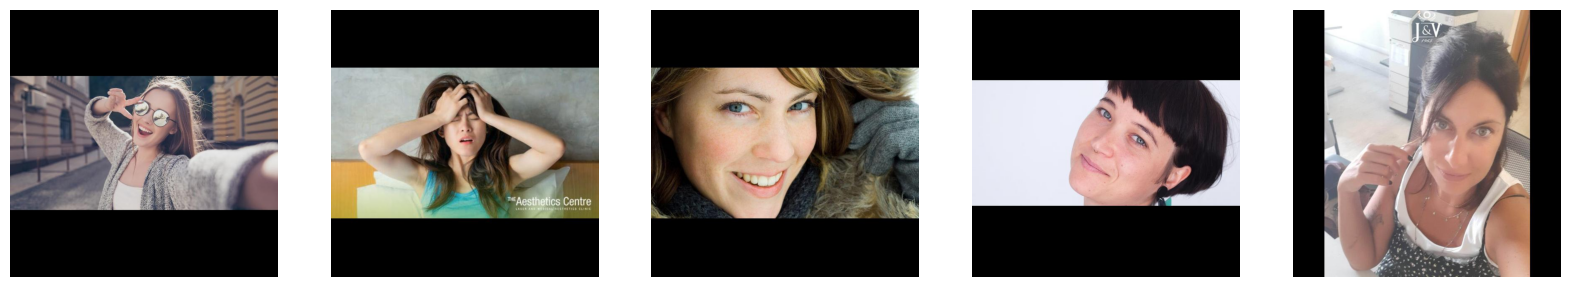

Class :  oily


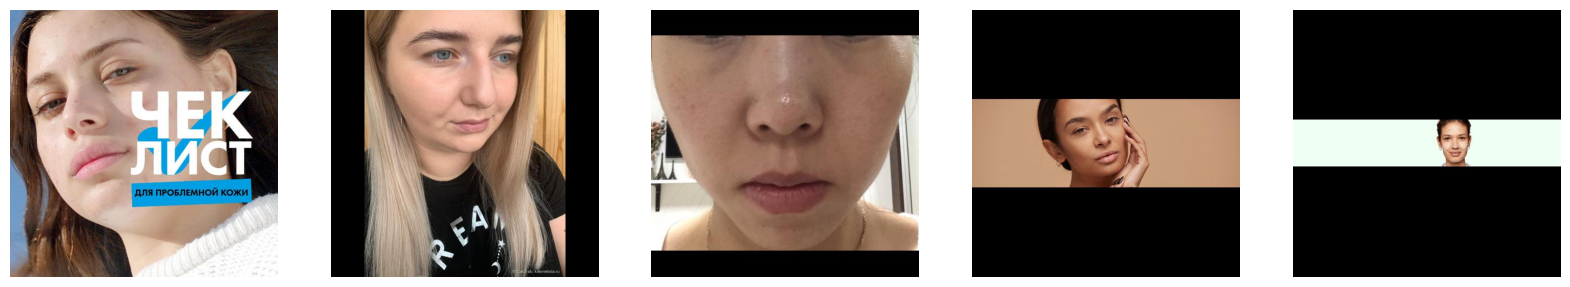

In [16]:
# Visualization of val_path

plot_images(val_path)

# 4. EDA

## A. Dimension Analysis and Image Ratio

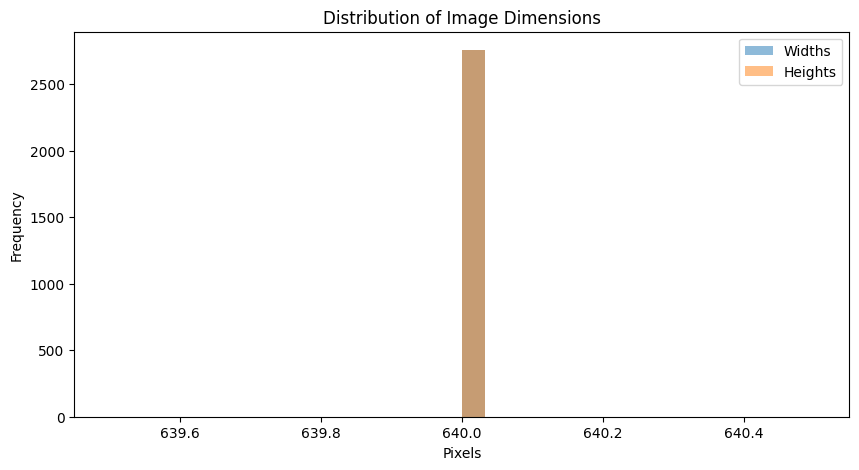

In [17]:
def analyze_image_dimensions(path):
    widths, heights = [], []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                with Image.open(img_path) as img:
                    widths.append(img.size[0])
                    heights.append(img.size[1])
    return np.array(widths), np.array(heights)

widths, heights = analyze_image_dimensions(train_path)

# Plot the distribution of widths and heights
plt.figure(figsize=(10, 5))
plt.hist(widths, bins=30, alpha=0.5, label='Widths')
plt.hist(heights, bins=30, alpha=0.5, label='Heights')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Image Dimensions')
plt.show()


Data used in this model is 640 pixel in heights

## B. Color Analysis

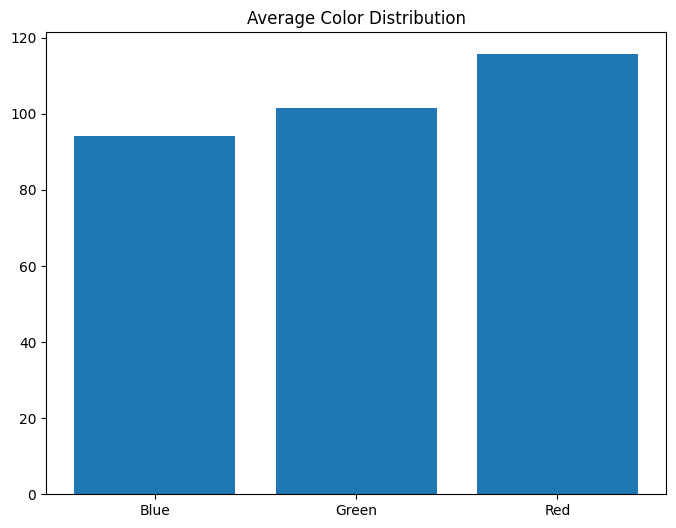

In [18]:
def average_color(path, sample_size=100):
    avg_colors = []
    count = 0
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                avg_color = img.mean(axis=(0, 1))  # Mean of BGR
                avg_colors.append(avg_color)
                count += 1
                if count >= sample_size:
                    break
    return np.array(avg_colors)

avg_colors = average_color(train_path, sample_size=500)

# Plot average color
plt.figure(figsize=(8, 6))
plt.bar(['Blue', 'Green', 'Red'], avg_colors.mean(axis=0))
plt.title('Average Color Distribution')
plt.show()


From the analysis above, it is safe to say that the red color has dominate the image dataset following green and blue in the 2nd and 3rd place

## C. Outliers Analysis

In [19]:
def find_outliers(widths, heights):
    w_mean, w_std = np.mean(widths), np.std(widths)
    h_mean, h_std = np.mean(heights), np.std(heights)
    outliers = [(w, h) for w, h in zip(widths, heights) if (w < w_mean - 3*w_std or w > w_mean + 3*w_std) or (h < h_mean - 3*h_std or h > h_mean + 3*h_std)]
    return outliers

outliers = find_outliers(widths, heights)
print(f"Number of outliers: {len(outliers)}")


Number of outliers: 0


Our data is pretty cool because it has zero outliers!

# 5. Feature Engineering

Feature engineering yang akan dilakukan  adalah preprocessing dengan 2 tahap, yaitu tanpa dan dengan augmentation. Parameter yang digunakan meliputi ukuran, tinggi dan lebar gambar. Pada proses augmentation, hyperparameter yang digunakan meliputi:
* Rotasi gambar sebanyak 25 derajat
* Zoom in/out sebanyak 15%
* Pergeseran lebar dan tinggi gambar sebanya 10%
* Validation split sebanyak 0.3 (data validation 30%)
Model dilakukan augmentasi dengan tujuan untuk meningkatkan performa model

## Preprocessing - Without Data Augmentation

In [20]:
# Define hyperparameters
# the size is in pixels

img_height= 220
img_width= 220
batch_size= 64

In [21]:
# Download pretrained model


pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
pretrained_model.trainable = False #froze the pretrained model untuk menghindari training ulang

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Pretrained model digunakan dengan tujuan menghemat waktu dan sumber daya serta meningkatkan akurasi dari model karena pretrained model biasanya sudah dilatih pada data yang lebih besar. Selain itu, pretrained model juga digunakan untuk mengurangi resiko overfitting

In [22]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True, #mengacak data untuk setiap epoch
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 1655 images belonging to 3 classes.
Found 1101 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


In [23]:
# Show labels

train_set.class_indices

{'dry': 0, 'normal': 1, 'oily': 2}

## Preprocessing - With Data Augmentation

Data augmentation aims to improve training dta diversity without actually adding data

In [24]:
# Define hyperparameters
# the size is in pixels

img_height= 220
img_width= 220
batch_size= 64

In [25]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., #scaling gambar 255 pixel
                                                                    rotation_range=25, #rotasi gambar 25 derajat
                                                                    zoom_range=0.15, #zoom in/out 15%
                                                                    width_shift_range=0.1, #pergeseran lebar gambar sebanyak 10% secara horizontal
                                                                    height_shift_range=0.1, #pergeseran tinggi gambar sebanyak 10% secara vertikal
                                                                    shear_range=0.00, #transformasi shear/geser) 5%
                                                                    horizontal_flip=False, #balik gambar secara horizontal
                                                                    validation_split=0.3) #membagi dataset menjadi 70% train set dan 30% validation

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='sparse',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 1930 images belonging to 3 classes.
Found 826 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


# 6. ANN Training (Sequential API/Functional API)

Model yang digunakan pada ANN Training adalah API Sequential

## Model Definition

In [26]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed) #memastikan angka acak yang dihasilkan tetap konsisten setiap kali kode dijalankan
tf.random.set_seed(seed)

#Define the model
model = tf.keras.models.Sequential()

# Flatten the output of the pretrained model
model = Sequential()
model.add(pretrained_model)  # Add pretrained model
model.add(Flatten())         # Flatten the output

#Input layer (100 neurons)
model.add(tf.keras.layers.Dense(100, activation='relu'))

#Hidden layers (80 neurons)
model.add(tf.keras.layers.Dense(80, kernel_initializer='GlorotUniform'))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(40, kernel_initializer='GlorotUniform'))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(20, kernel_initializer='GlorotUniform'))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(8, kernel_initializer='GlorotUniform'))
model.add(tf.keras.layers.Activation('relu'))

#Output layers
model.add(tf.keras.layers.Dense(3, activation='softmax'))


# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 6, 6, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       1,843,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 80)                  │           8,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,570,323 (63.21 MB)

 Trainable params: 1,855,635 (7.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

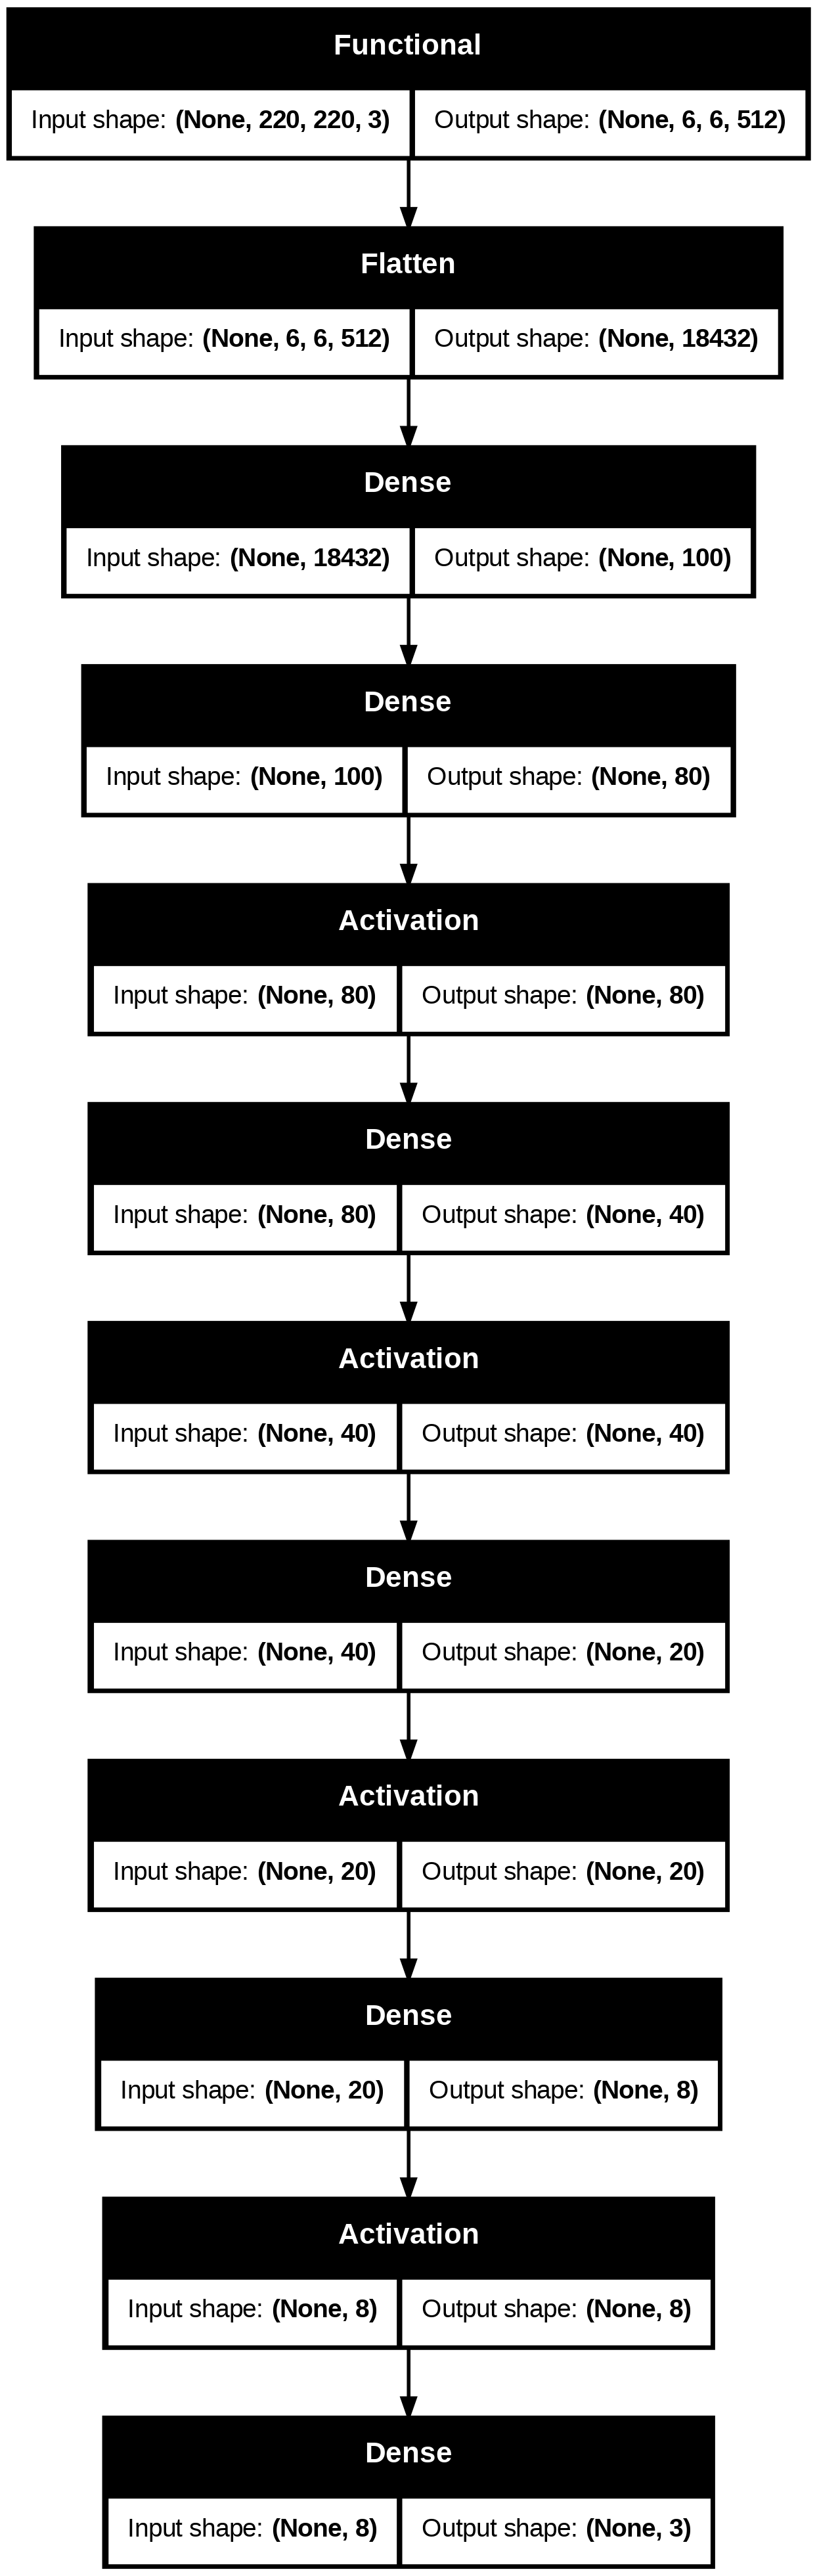

In [27]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## Model Training

In [28]:
# Train the model

history_base = model.fit(train_set, epochs=25, validation_data=val_set, batch_size=batch_size)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.3667 - loss: 1.2223 - val_accuracy: 0.3742 - val_loss: 1.0902
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 474ms/step - accuracy: 0.5137 - loss: 0.9780 - val_accuracy: 0.4015 - val_loss: 1.1412
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - accuracy: 0.6728 - loss: 0.7657 - val_accuracy: 0.3915 - val_loss: 1.2861
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - accuracy: 0.7845 - loss: 0.5593 - val_accuracy: 0.4342 - val_loss: 1.4338
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 486ms/step - accuracy: 0.8495 - loss: 0.4489 - val_accuracy: 0.4223 - val_loss: 1.6213
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 490ms/step - accuracy: 0.9349 - loss: 0.2340 - val_accuracy: 0.4169 - val_loss: 1.7618
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 490ms/step - accuracy: 0.9808 - loss: 0.1211 - val_accuracy: 0.4169 - val_loss: 2.0604
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 502ms/step - accuracy: 0.9967 - loss: 0.0563 - val_accuracy: 0.4396 -

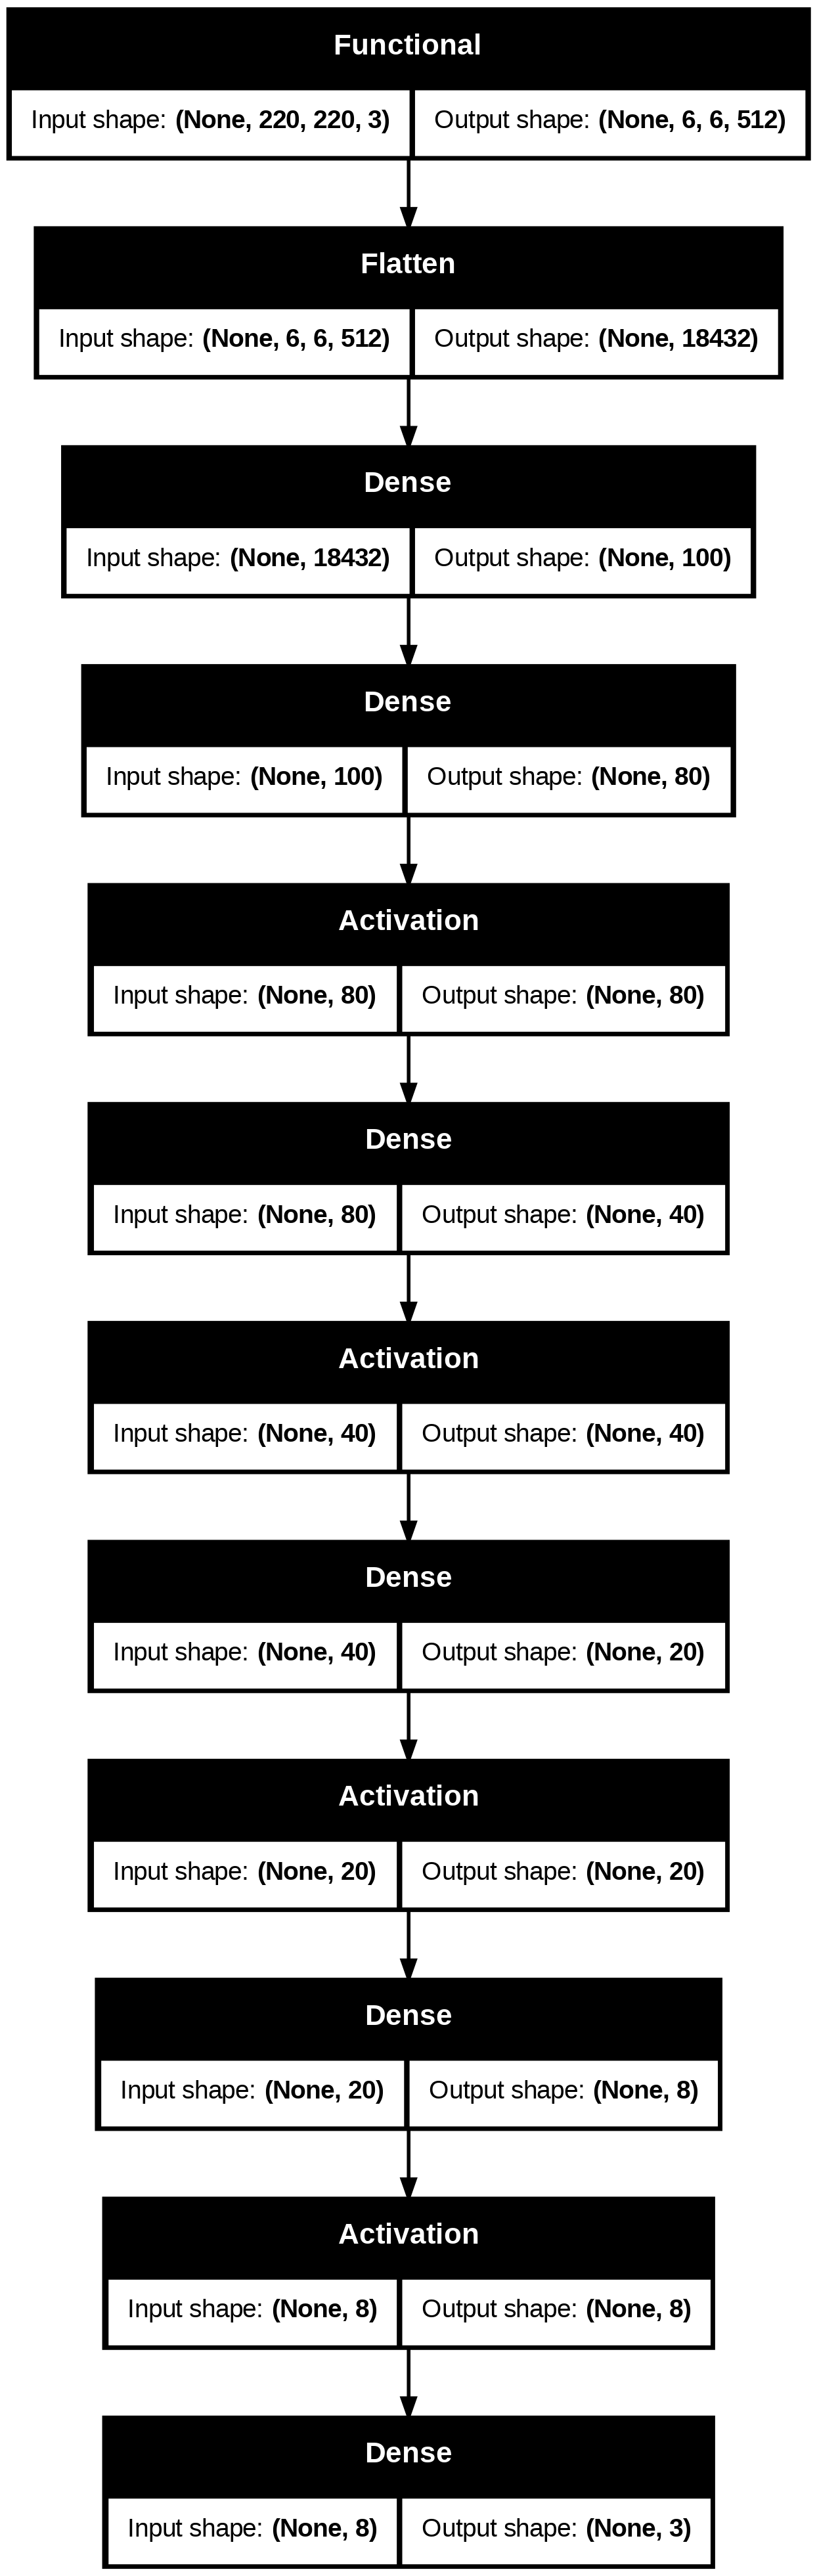

In [29]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## Model Evaluation

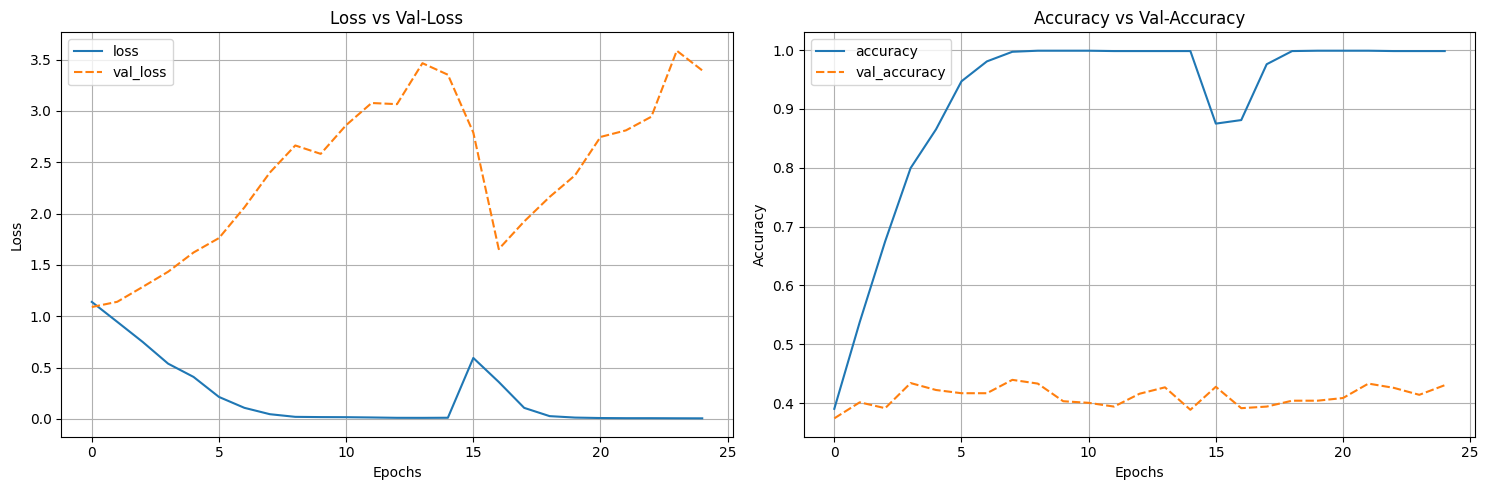

In [30]:
# Ubah history_base.history menjadi DataFrame
history_df = pd.DataFrame(history_base.history)

# Plot training results
plt.figure(figsize=(15, 5))

# Loss vs Val-Loss
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy vs Val-Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


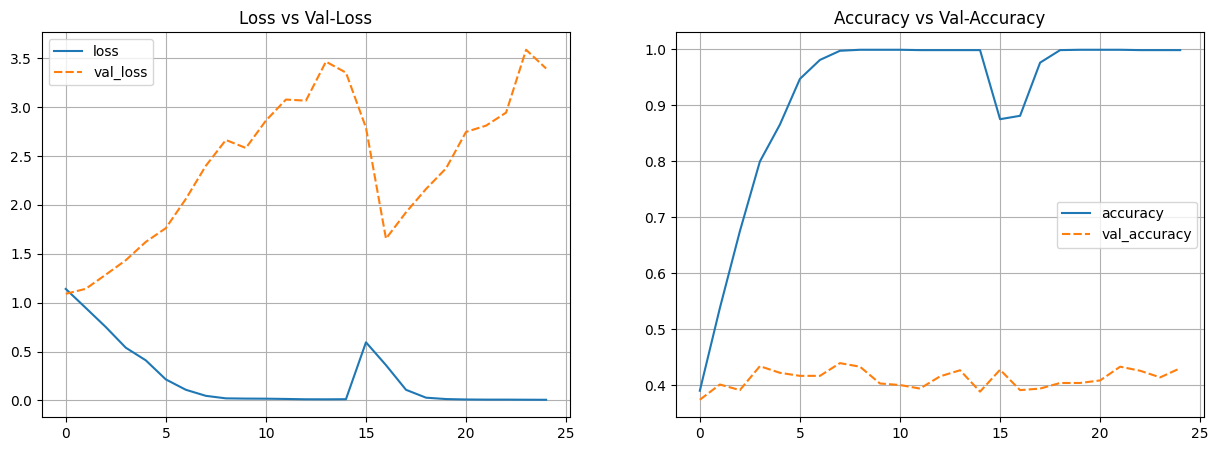

In [31]:
# Plot training results

history_df = pd.DataFrame(history_base.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Based on the calculation above, the model tends to be overfitting. We'll try to fix this problem in the next slide

# 7. ANN Improvement (Sequential API/Functional API)

## Model Definition

Pada bagian ini akan dilakukan menggunakan Sequential API juga seperti proses yang sudah dilakukan pada tahap sebelumnya. Hanya saja, pada bagia ini akan dilakukan improvement untuk meningkatkan performa model. Improvement dilakukan dengan cara menambah layer dan menambahkan learning rate sebanyak 0.0001. Learning rate bertujuan untuk mengarahkan model mempelajari data yang disediakan. Semakin kecil nilai learning rate, semakin lama proses training karena model akan memperbarui parameter lebih sedikit pada setiap iterasi, sehingga membutuhkan lebih banyak iterasi untuk mencapai konvergensi. Maka, semakin lama juga waktu yang diperlukan untuk training

In [32]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the model
model_aug = tf.keras.models.Sequential()
# model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
# model_aug.add(MaxPooling2D(2, 2))

# Add pretrained model and Flatten layer
model_aug.add(pretrained_model)  # Add pretrained model
model_aug.add(Flatten())         # Flatten the output

# Input layer (100 neurons)
model_aug.add(tf.keras.layers.Dense(100, activation='relu'))

# Hidden layers
model_aug.add(tf.keras.layers.Dense(90, kernel_initializer='GlorotUniform', activation='relu'))
model_aug.add(Dropout(0.6))
model_aug.add(tf.keras.layers.Dense(75, kernel_initializer='GlorotUniform', activation='relu'))
model_aug.add(Dropout(0.6))
model_aug.add(tf.keras.layers.Dense(50, kernel_initializer='GlorotUniform', activation='relu'))
model_aug.add(tf.keras.layers.Dense(40, kernel_initializer='GlorotUniform', activation='relu'))
model_aug.add(tf.keras.layers.Dense(20, kernel_initializer='GlorotUniform', activation='relu'))
model_aug.add(tf.keras.layers.Dense(8, kernel_initializer='GlorotUniform', activation='relu'))

# Output layer
model_aug.add(tf.keras.layers.Dense(3, activation='softmax'))

# Compile the model
model_aug.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

# Summary
model_aug.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 6, 6, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       1,843,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │           9,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 75)                  │           6,825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           3,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 40)                  │           2,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,580,758 (63.25 MB)

 Trainable params: 1,866,070 (7.12 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

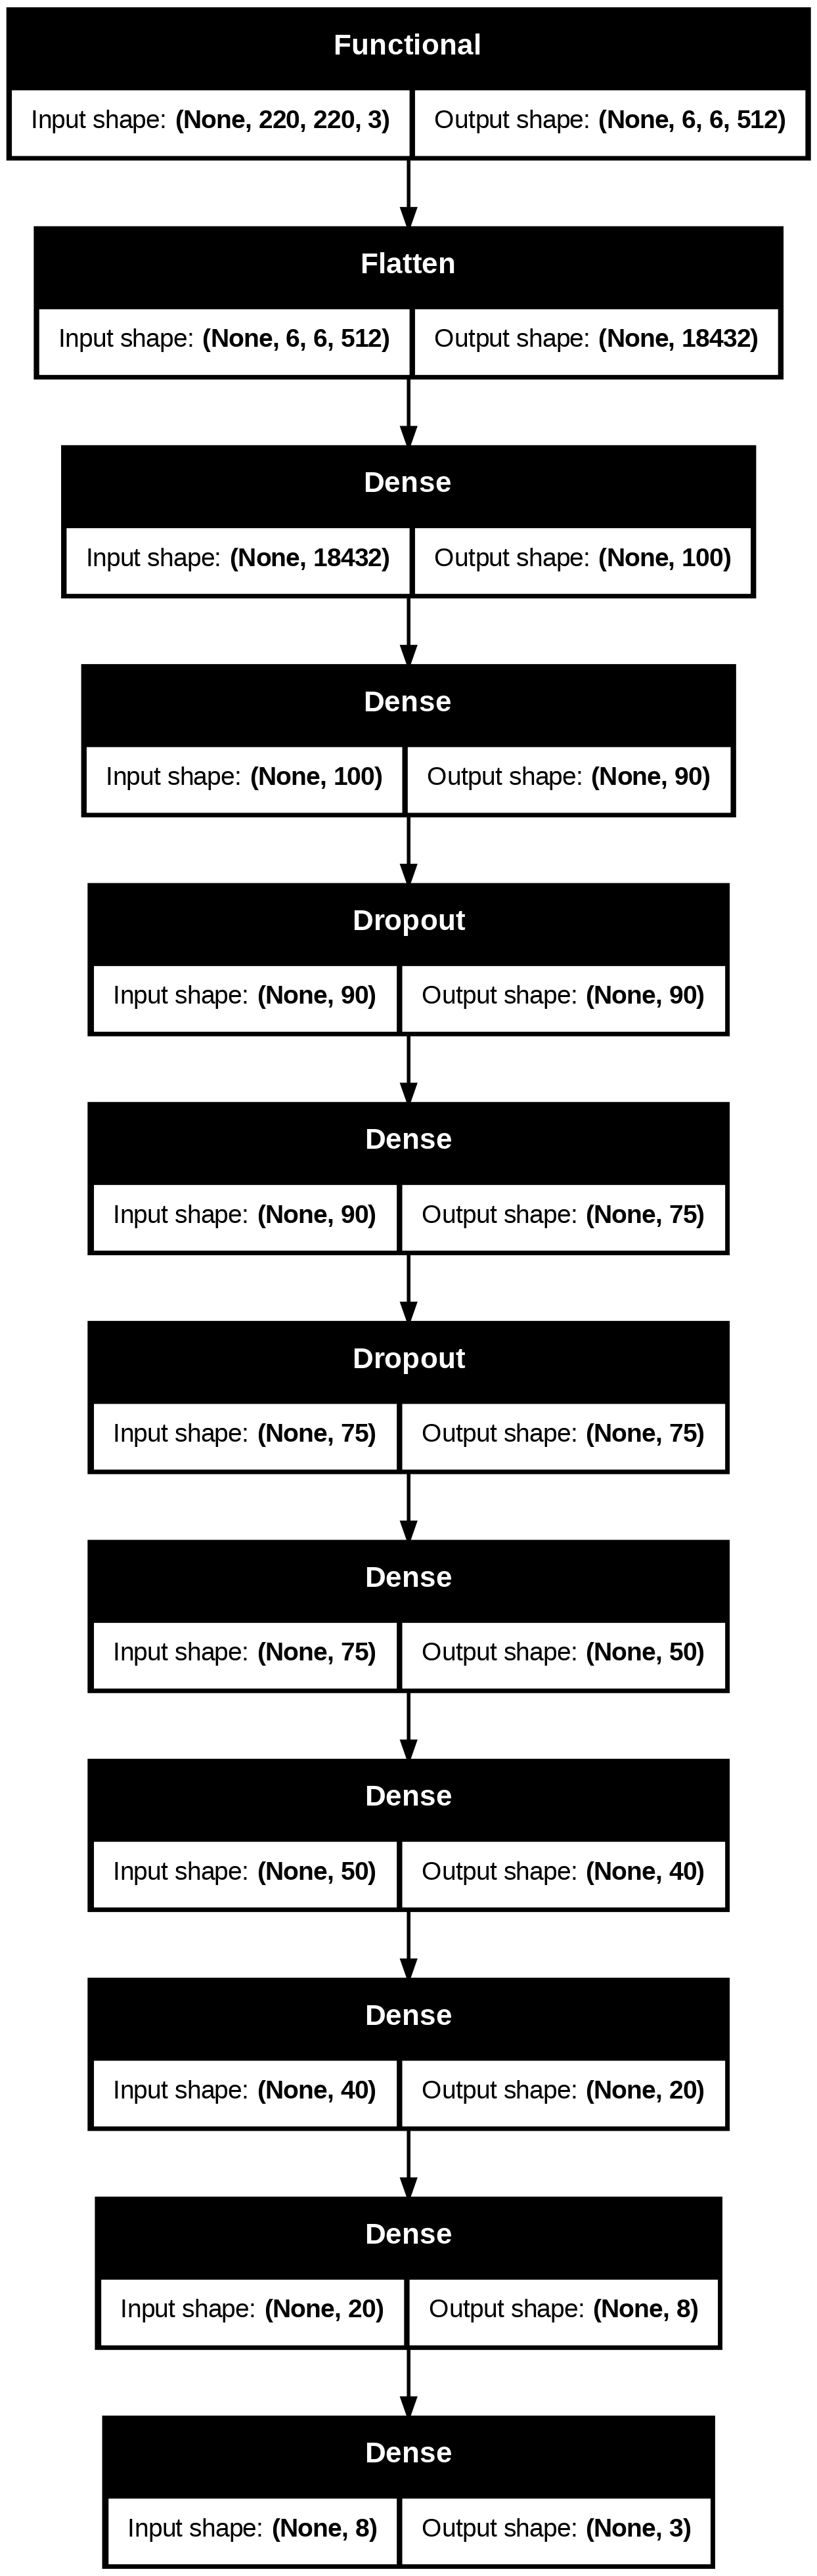

In [33]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

## Model Training

In [34]:
# Train the model

history_aug = model_aug.fit(train_set_aug, epochs=25, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3434 - loss: 1.1472 - val_accuracy: 0.3632 - val_loss: 1.0915
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.3307 - loss: 1.1152 - val_accuracy: 0.3632 - val_loss: 1.0913
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3553 - loss: 1.0963 - val_accuracy: 0.3632 - val_loss: 1.0854
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3636 - loss: 1.1018 - val_accuracy: 0.3632 - val_loss: 1.0863
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3682 - loss: 1.0831 - val_accuracy: 0.3632 - val_loss: 1.0860
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4180 - loss: 1.0722 - val_accuracy: 0.3632 - val_loss: 1.0854
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3291 - loss: 1.0938 - val_accuracy: 0.3632 - val_loss: 1.0890
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3597 - loss: 1.0991 - val_accuracy: 0.3632 - val_loss: 1.0865
Epo

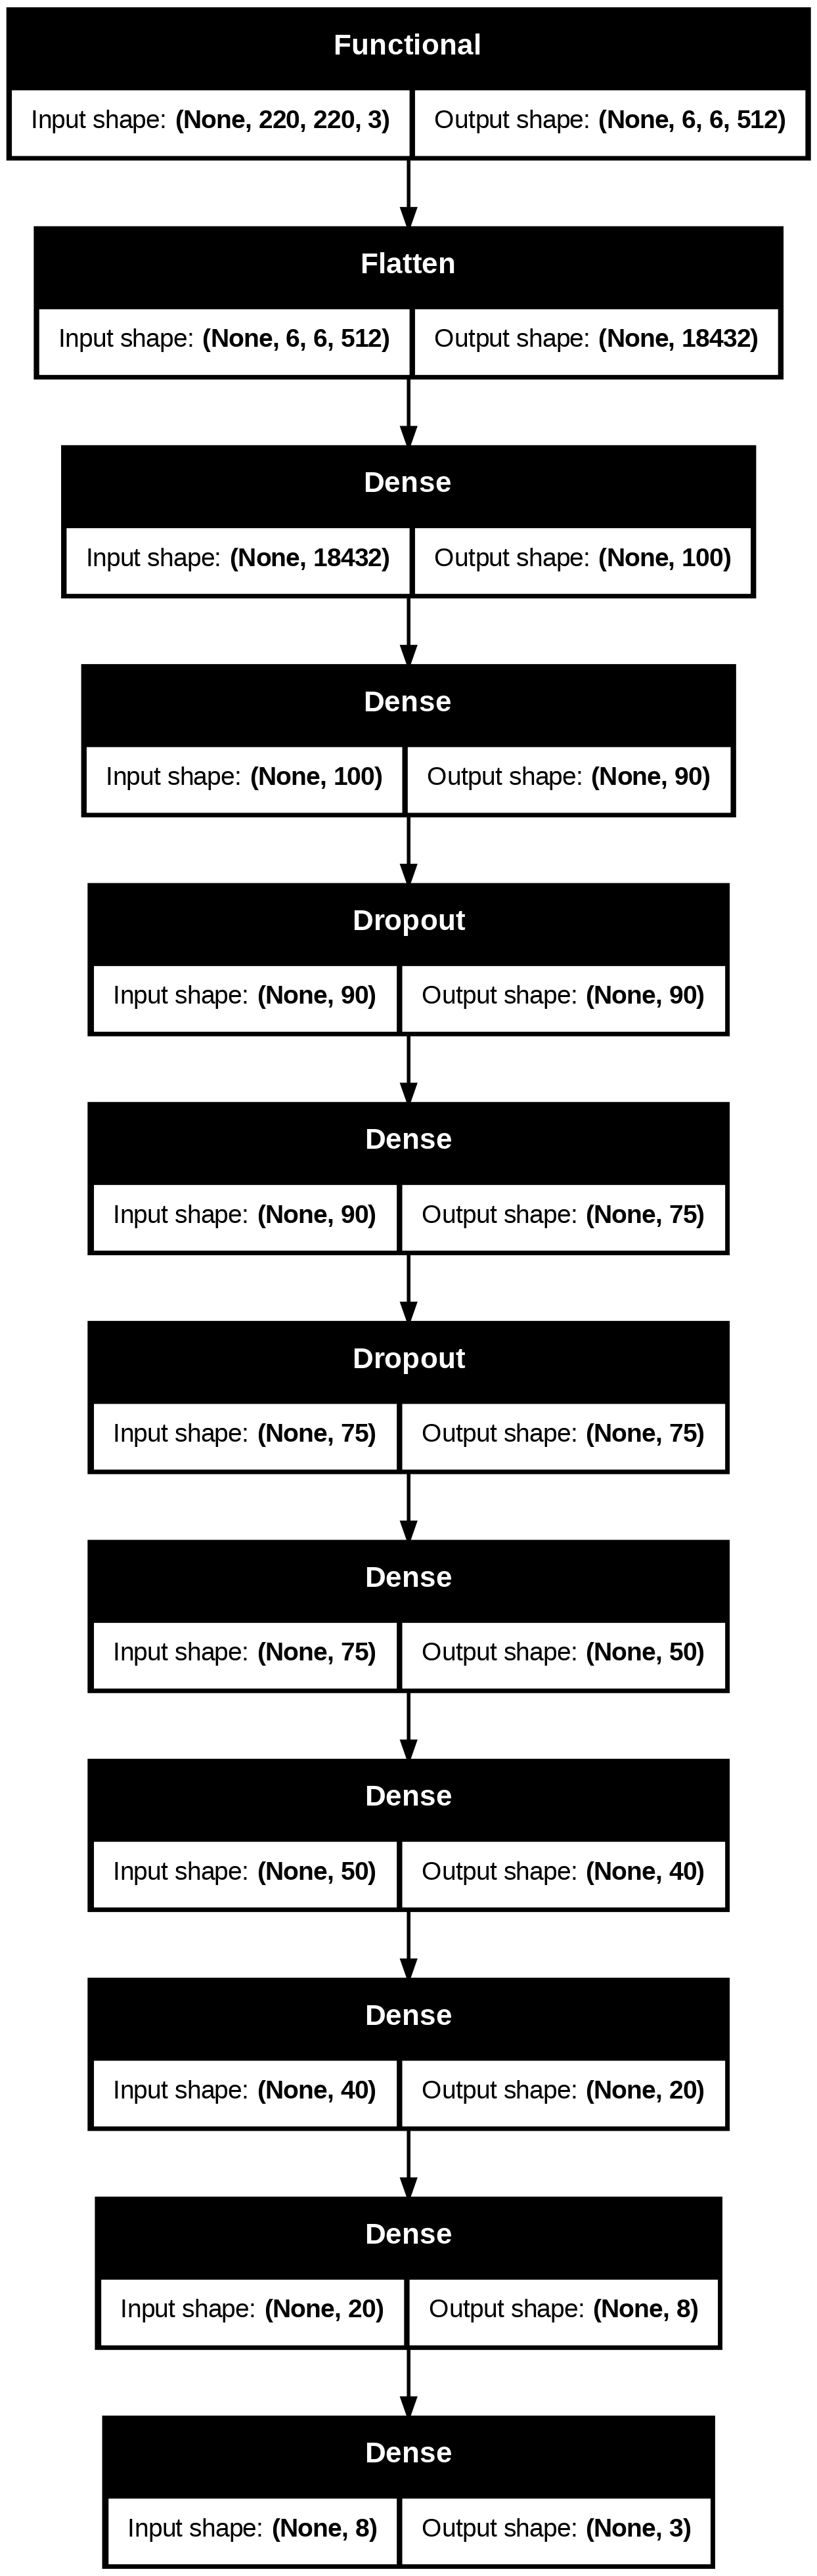

In [35]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

## Model Evaluation

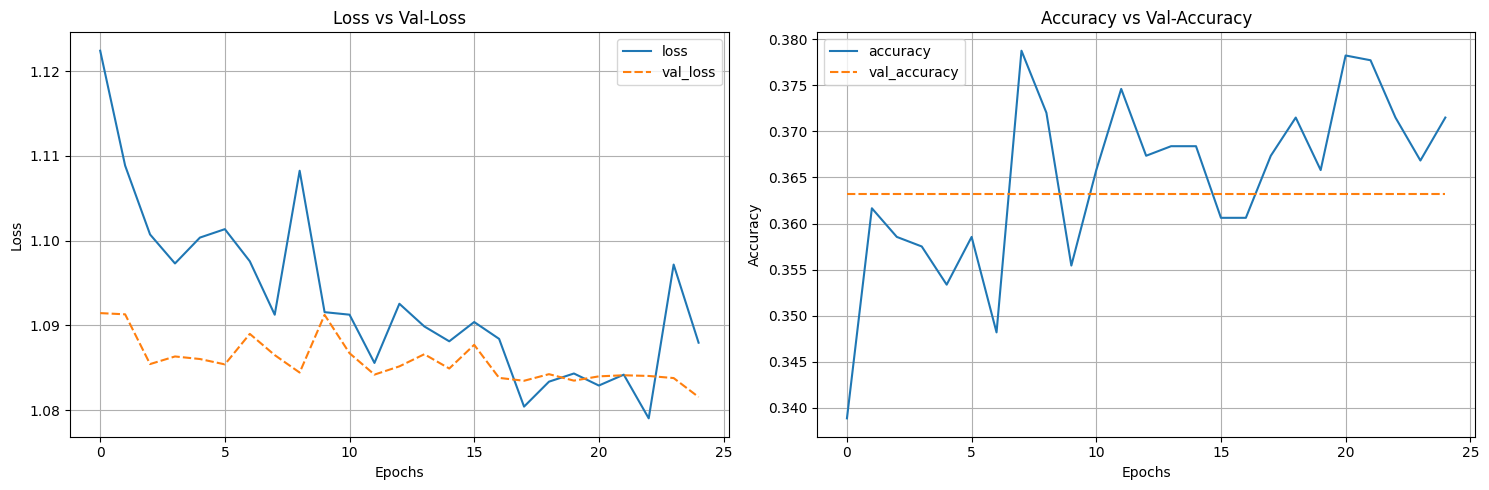

In [36]:
# Ubah history_base.history menjadi DataFrame
history_df_aug = pd.DataFrame(history_aug.history)

# Plot training results
plt.figure(figsize=(15, 5))

# Loss vs Val-Loss
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df_aug[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy vs Val-Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df_aug[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


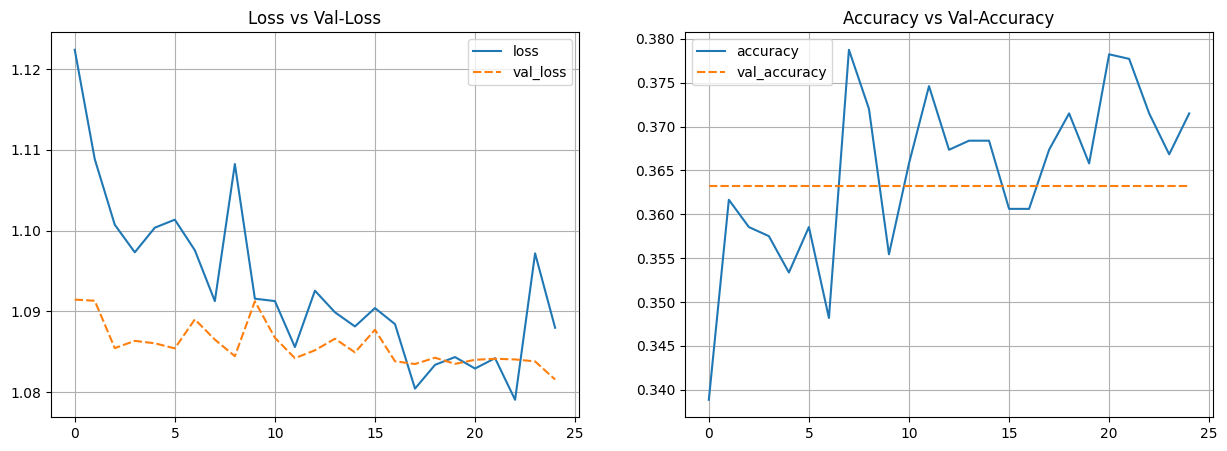

In [37]:
# Plot training results

history_df_aug = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df_aug[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df_aug[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Model berhasil diimprove dengan cara menurunkan selisih antara accuracy dan juga val_accuracy. Epoch terbaik yang menghasilkan hasil yang paling baik ada pada epoch 9 dan 13

## Post Training EDA

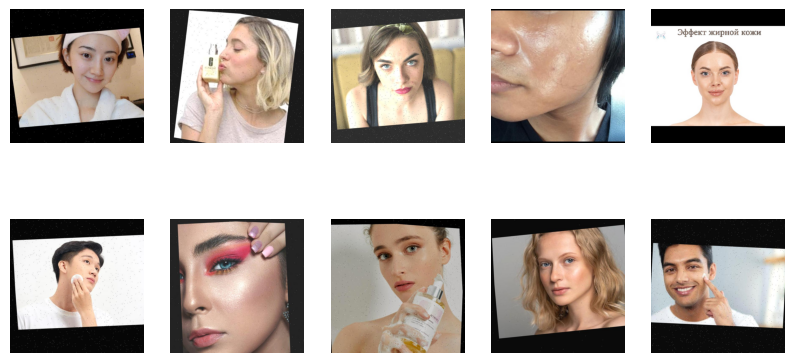

In [38]:
# Ambil beberapa contoh gambar dari train
path = os.path.join(train_path, 'oily')  # Contoh kategori Oily
images = [cv2.imread(os.path.join(path, img)) for img in os.listdir(path)[:10]]

# Tampilkan gambar
plt.figure(figsize=(10, 5))
for i, img in enumerate(images):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()


In [39]:
# Flow from directory akan otomatis memisahkan x_train dan y_train
train_data = train_datagen.flow_from_directory(
    train_path,  # Folder train
    target_size=(img_height, img_width),  # Ukuran gambar
    batch_size=batch_size,
    class_mode='categorical'  # Output y_train dalam one-hot encoding
)

# Contoh akses x_train dan y_train
x_train, y_train = next(train_data)  # Ambil satu batch data

print("Shape x_train:", x_train.shape)  # Misal: (32, 224, 224, 3) untuk 32 gambar
print("Shape y_train:", y_train.shape)  # Misal: (32, 3) untuk 3 kelas


Found 2756 images belonging to 3 classes.
Shape x_train: (64, 220, 220, 3)
Shape y_train: (64, 3)


### 1) Histogram Colour Analysis for Every Skin Type

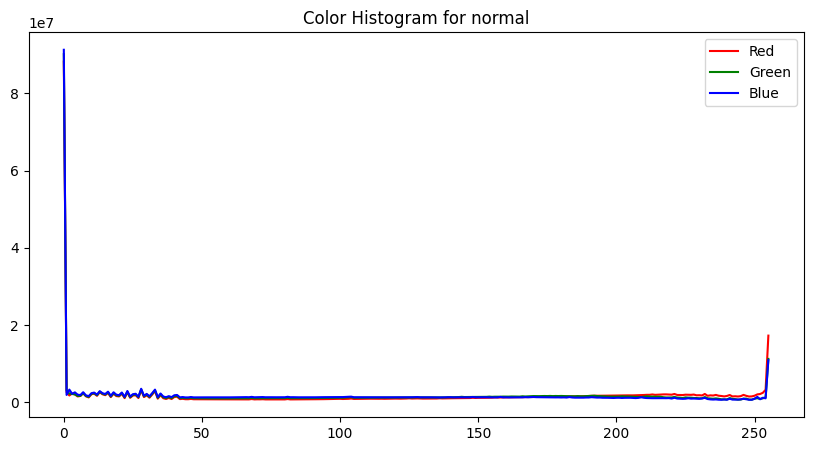

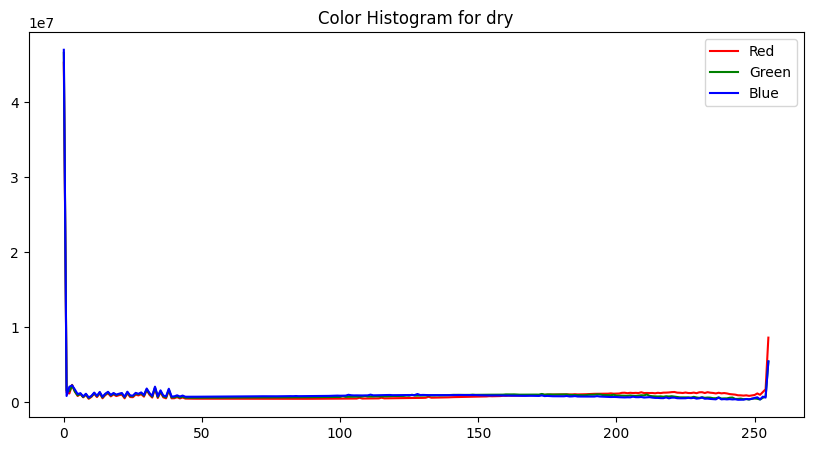

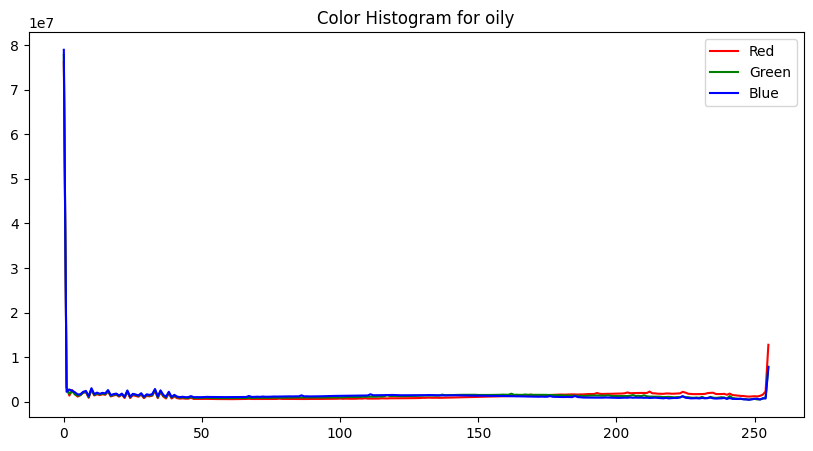

In [40]:
# Path ke folder train
classes = os.listdir(train_path)  # Pastikan train_path adalah path asli folder train

for skin_type in classes:
    path = os.path.join(train_path, skin_type)  # Iterasi tiap folder kelas
    hist_r, hist_g, hist_b = np.zeros(256), np.zeros(256), np.zeros(256)

    # Iterasi setiap gambar dalam kelas
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            hist_r += cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()  # Red channel
            hist_g += cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()  # Green channel
            hist_b += cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()  # Blue channel

    # Plot histogram warna
    plt.figure(figsize=(10, 5))
    plt.title(f'Color Histogram for {skin_type}')
    plt.plot(hist_r, color='r', label='Red')
    plt.plot(hist_g, color='g', label='Green')
    plt.plot(hist_b, color='b', label='Blue')
    plt.legend()
    plt.show()


Dari hasil analisa di atas, dapat kita simpulkan bahwa tidak terdapat perbedaan yang signifikan terhadap spektrum warna yang mendominasi terhadap satu jenis kulit tertentu. Hal ini bisa jadi karena pengambilan gambar yang tidak terstandarisasi sehingga data banyak yang menjadi bias karena cahaya kamera

### 2) Texture Analysis for Every Skin Type

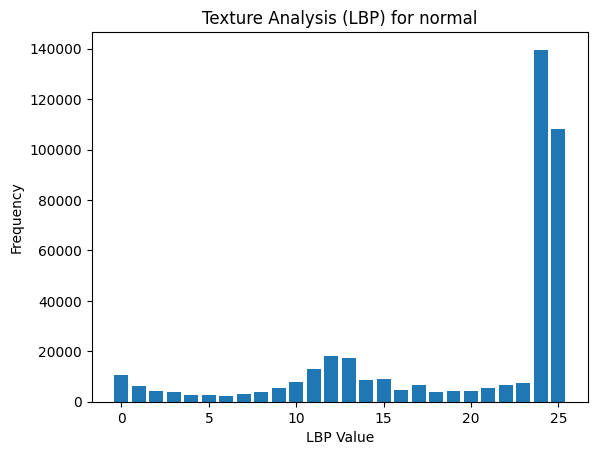

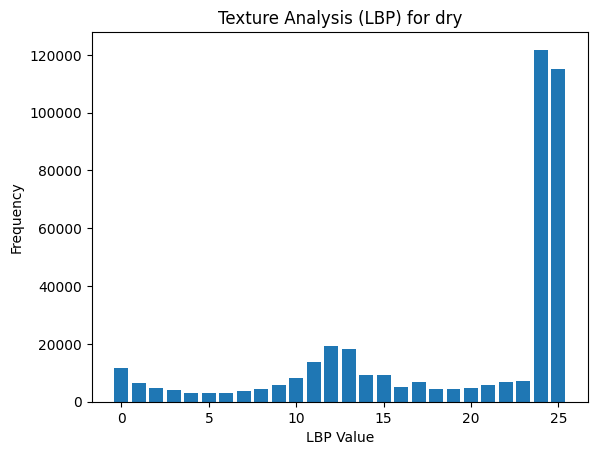

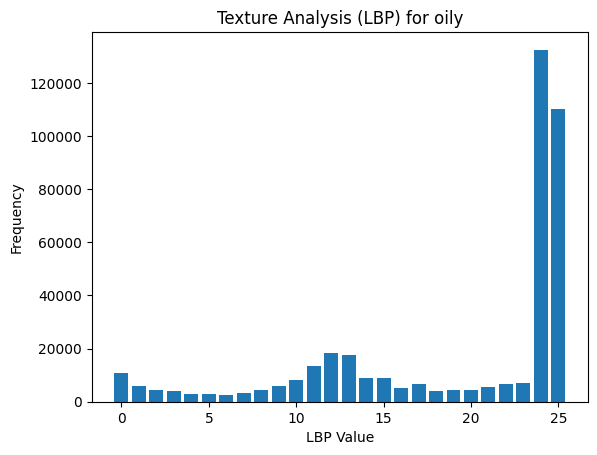

In [41]:
# Parameter LBP
radius = 3
n_points = 8 * radius

for skin_type in classes:
    path = os.path.join(train_path, skin_type)
    lbp_values = []

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            lbp = local_binary_pattern(img, n_points, radius, method='uniform')
            lbp_values.append(np.histogram(lbp.ravel(), bins=range(0, n_points + 3))[0])

    # Plot rata-rata histogram LBP
    avg_lbp = np.mean(lbp_values, axis=0)
    plt.bar(range(len(avg_lbp)), avg_lbp)
    plt.title(f'Texture Analysis (LBP) for {skin_type}')
    plt.xlabel('LBP Value')
    plt.ylabel('Frequency')
    plt.show()


Dari hasil analisa di atas, dapat dilihat bahwa hampir tidak terdapat perbedaan yang mencolok terhadap masing-masing tipe kulit. Hal ini bisa jadi disebabkan karena responden yang menjadi sumber data dalam pembuatan model ini banyak yang menggunakan make up sehingga tidak terlalu terlihat tekstur kulit wajah yang asli

### 3) Pores and Spot Analysis for Every Skin Type

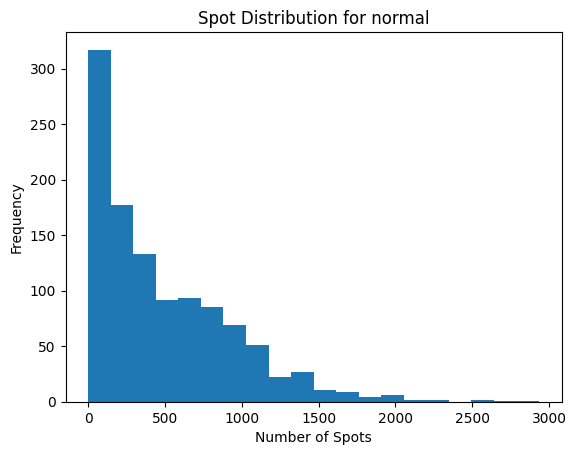

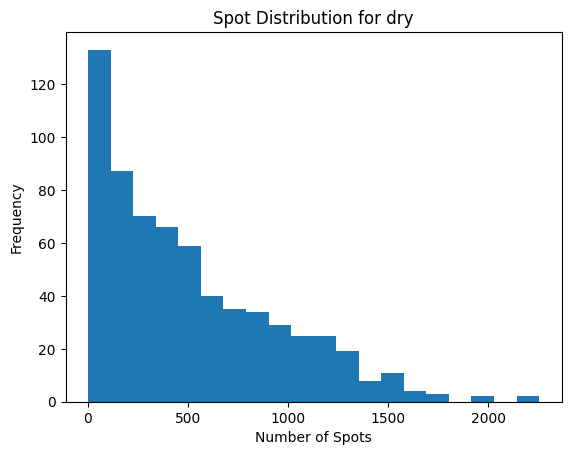

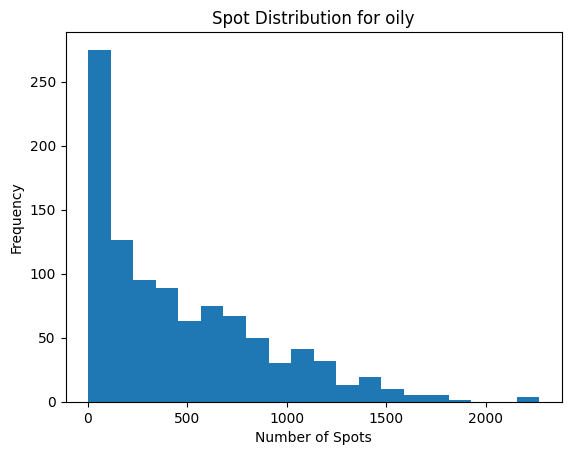

In [42]:
for skin_type in classes:
    path = os.path.join(train_path, skin_type)
    spot_counts = []

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Preprocessing
            _, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY_INV)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Hitung jumlah spot (contours)
            spot_counts.append(len(contours))

    # Plot distribusi jumlah spot
    plt.hist(spot_counts, bins=20)
    plt.title(f'Spot Distribution for {skin_type}')
    plt.xlabel('Number of Spots')
    plt.ylabel('Frequency')
    plt.show()


Dari hasil analisa di atas, dapat disimpulkan bahwa tipe kulit normal cenderung memiliki lebih banyak pori dan spot dibandingkan dengan tipe kulit lain. Urutan tipe kulit yang memiliki spot dan pori yang banyak:
1. Kulit Normal
2. Kulit Berminyak
3. Kulit Kering

# 8. Model Saving

In [43]:
model_aug.save('model_aug.keras')
print("Model has successfully saved!")

Model has successfully saved!


In [44]:
model_aug.save('/content/drive/MyDrive/model_aug.keras')


In [45]:
from google.colab import files
files.download('model_aug.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 10. Conclusion

* Hal yang bisa dijadikan acuan dalam menentukan jenis kulit wajah bagi dokter dan juga individu sebelum menentukan jenis skincare dan treatment yang akan dilakukan adalah dengan melihat banyaknya pori dan juga spot pada kulit
* Urutan jenis kulit yang memiliki spot/pori yang peling banyak adalah:
  1. Kulit Normal
  2. Kulit Berminyak
  3. Kulit Kering
* Model ini dilatih menggunakan pretrained model  dengan tujuan menghemat waktu dan sumber daya serta meningkatkan akurasi dari model karena pretrained model biasanya sudah dilatih pada data yang lebih besar. Selain itu, pretrained model juga digunakan untuk mengurangi resiko overfitting
* Pada proses augmentation, hyperparameter yang digunakan meliputi:
  - Rotasi gambar sebanyak 25 derajat
  - Zoom in/out sebanyak 15%
  - Pergeseran lebar dan tinggi gambar sebanya 10%
  - Validation split sebanyak 0.3 (data validation 30%)
  Model dilakukan augmentasi dengan tujuan untuk meningkatkan performa model
* Dataset yang tidak diaugmentasi tetap digunakan untuk keperluan evaluasi model serta memastikan model tidak hanya belajar dari data yang telah diaugmentasi
* Penggunaan layer convolutional tidak digunakan karena model ini menggunakan pretrained model yang biasanya sudah mengandung layer convolutional sehingga Convo tidak lagi diperlukan
* Model ini bersifat good fit karena selisih yang kecil antara accuracy dan val_accuracy dengan hasil terbaik berada pada epoch 9 dan 13 dengan selisih antara accuracy dengan val accuracy berkisar di angka 0.8
* Namun kekurangannya adalah model cenderung kurang baik dalam melakukan prediksi gambar. Saran perbaikan untuk meningkatkan performa model adalah dengan memperbaiki dataset mulai dari penyeragaman saat pengambilan data yang meliputi setting cahaya yang seragam dan juga responden yang mengambil data tanpa menggunakan make up. Hal ini dilakukan untuk meningkatkan akurasi dan performa model yang lebih baik
* Kelebihan dari model ini adalah memiliki waktu training yang cepat dan tidak cenderung overitting